In [109]:
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 21 14:26:17 2020

@author: shvpr
"""

from io import StringIO
from datetime import date
from datetime import datetime
import time
import pandas as pd
from util import notebook_utils
from util import fcst_utils
import dateutil.parser
today=date.today()
status_indicator = notebook_utils.StatusIndicator()

# AWS libraries
import boto3


#def main():
    

# AWS credentials through named profile.
boto3.setup_default_session(profile_name='HCL_USER_1')

# Bucket to store the cleaned data for amazon forecast
bucket_name="test-forecast-example"
prefix="capplan_data/"
key=prefix+"amazon_forecast_input.csv"
relatedKey=prefix+"related_timeseries_amazon_forecast.csv"
role_name="ForecastAccessS3Role"
role_arn="arn:aws:iam::311461407286:role/ForecastAccessS3Role"
project = 'capacity_plan_forecast_deepAR'
predictorName= project+'_deepAR_algo'
algorithmArn = 'arn:aws:forecast:::algorithm/Deep_AR_Plus'
forecastName= project+'_deepAR_algo_forecast'
forecastHorizon = 24

# Bucket containing the input data
# mybucket = "capacityplanning"
# myprefix="cloudwatch_metricdata/"

# Bucket to store the predictions in the form of csv files
new_bucket="capacityplanning-predictions-bucket"
s3_output_path = "predictions/"
Deep_key = s3_output_path+"deepAR.csv"
#Deep_Ops_key = s3_output_path+"DEEPAR_WRITEOPS"+str(today)+".csv"
Deep_RMSE_key = s3_output_path+"rmse_deepAR.txt"

#DeepAR_key = s3_output_path+"PREDICTIONS_FUTURE_DEEPAR"+str(today)+".csv"

# Setting up clients for S3, forecast, forecastquery.
client = boto3.client('s3')
forecast=boto3.client('forecast')
forecastquery=boto3.client('forecastquery')

In [110]:
# Preparing data for the forecast
# creating the target time series dataset
#def initialize_data_forecast():
DATASET_FREQUENCY = "H" 
TIMESTAMP_FORMAT = "yyyy-MM-dd HH:mm:ss"
ts_datasetName= project+'_tsds'
dataset_arns = []
datasetGroupName= project +'_dsg'
s3DataPath = "s3://"+bucket_name+"/"+key
s3DataPathRelated = "s3://"+bucket_name+"/"+relatedKey

create_dataset_group_response = forecast.create_dataset_group(Domain="CUSTOM",
                                                        DatasetGroupName=datasetGroupName
                                                        #DatasetArns=dataset_arns
                                                         )
# print(f'Creating dataset group {datasetGroupName}')
# datasetGroupArn = create_dataset_group_response['DatasetGroupArn']
# forecast.describe_dataset_group(DatasetGroupArn=datasetGroupArn)
   

#return datasetGroupArn, datasetArn, datasetName, project, s3DataPath, DATASET_FREQUENCY, TIMESTAMP_FORMAT

In [111]:
print(f'Creating dataset group {datasetGroupName}')

Creating dataset group capacity_plan_forecast_deepAR_dsg


In [112]:
datasetGroupArn = create_dataset_group_response['DatasetGroupArn']
forecast.describe_dataset_group(DatasetGroupArn=datasetGroupArn)
   

{'DatasetGroupName': 'capacity_plan_forecast_deepAR_dsg',
 'DatasetGroupArn': 'arn:aws:forecast:us-east-1:311461407286:dataset-group/capacity_plan_forecast_deepAR_dsg',
 'DatasetArns': [],
 'Domain': 'CUSTOM',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 12, 4, 18, 40, 57, 522000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2020, 12, 4, 18, 40, 57, 522000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '0173e99a-739a-48eb-95f8-4727ba8d8ab3',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 05 Dec 2020 02:41:04 GMT',
   'x-amzn-requestid': '0173e99a-739a-48eb-95f8-4727ba8d8ab3',
   'content-length': '289',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [113]:
print(f'the dataset name {ts_datasetName}')

the dataset name capacity_plan_forecast_deepAR_tsds


In [114]:
 ts_schema ={
   "Attributes":[
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      },
      {
         "AttributeName":"target_value",
         "AttributeType":"float"
      }
   ]
}
    
# print(f'Creating target dataset {ts_datasetName}')
# response=forecast.create_dataset(
#                 Domain="CUSTOM",
#                 DatasetType='TARGET_TIME_SERIES',
#                 DatasetName=ts_datasetName,
#                 DataFrequency=DATASET_FREQUENCY, 
#                 Schema = ts_schema)
# ts_datasetArn=response['DatasetArn']
# #forecast.update_dataset_group(DatasetGroupArn=datasetGroupArn, DatasetArns=[datasetArn])
# forecast.describe_dataset(DatasetArn=ts_datasetArn)

In [115]:
print(f'Creating target dataset {ts_datasetName}')

Creating target dataset capacity_plan_forecast_deepAR_tsds


In [116]:
response=forecast.create_dataset(
                Domain="CUSTOM",
                DatasetType='TARGET_TIME_SERIES',
                DatasetName=ts_datasetName,
                DataFrequency=DATASET_FREQUENCY, 
                Schema = ts_schema)

In [117]:
ts_datasetArn=response['DatasetArn']

In [118]:
forecast.describe_dataset(DatasetArn=ts_datasetArn)

{'DatasetArn': 'arn:aws:forecast:us-east-1:311461407286:dataset/capacity_plan_forecast_deepAR_tsds',
 'DatasetName': 'capacity_plan_forecast_deepAR_tsds',
 'Domain': 'CUSTOM',
 'DatasetType': 'TARGET_TIME_SERIES',
 'DataFrequency': 'H',
 'Schema': {'Attributes': [{'AttributeName': 'timestamp',
    'AttributeType': 'timestamp'},
   {'AttributeName': 'item_id', 'AttributeType': 'string'},
   {'AttributeName': 'target_value', 'AttributeType': 'float'}]},
 'EncryptionConfig': {},
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 12, 4, 18, 41, 15, 882000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2020, 12, 4, 18, 41, 15, 882000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '8e990796-e8f8-4b7e-8929-0357e472d6e0',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 05 Dec 2020 02:41:17 GMT',
   'x-amzn-requestid': '8e990796-e8f8-4b7e-8929-0357e472d6e0',
   'content-length': '529',
   'connection': 

In [119]:
#Creating the related time series dataset.
related_datasetName = f"{project}_related_ds"
print(related_datasetName)

capacity_plan_forecast_deepAR_related_ds


In [120]:
# specify the schema for the related time series dataset.
related_schema ={
"Attributes":[
  {
     "AttributeName":"timestamp",
     "AttributeType":"timestamp"
  },
  {
     "AttributeName":"item_id",
     "AttributeType":"string"
  },
  {
     "AttributeName":"lifetime",
     "AttributeType":"float"
  },
  {
     "AttributeName":"corehour",
     "AttributeType":"float"
  }
]
}

In [121]:
print(f'Creating related dataset {related_schema}')

Creating related dataset {'Attributes': [{'AttributeName': 'timestamp', 'AttributeType': 'timestamp'}, {'AttributeName': 'item_id', 'AttributeType': 'string'}, {'AttributeName': 'lifetime', 'AttributeType': 'float'}, {'AttributeName': 'corehour', 'AttributeType': 'float'}]}


In [122]:
response = forecast.create_dataset(Domain="CUSTOM",
                               DatasetType='RELATED_TIME_SERIES',
                               DatasetName=related_datasetName,
                               DataFrequency=DATASET_FREQUENCY,
                               Schema=related_schema
                              )

In [123]:
related_datasetArn = response['DatasetArn']

In [124]:
forecast.describe_dataset(DatasetArn=related_datasetArn)

{'DatasetArn': 'arn:aws:forecast:us-east-1:311461407286:dataset/capacity_plan_forecast_deepAR_related_ds',
 'DatasetName': 'capacity_plan_forecast_deepAR_related_ds',
 'Domain': 'CUSTOM',
 'DatasetType': 'RELATED_TIME_SERIES',
 'DataFrequency': 'H',
 'Schema': {'Attributes': [{'AttributeName': 'timestamp',
    'AttributeType': 'timestamp'},
   {'AttributeName': 'item_id', 'AttributeType': 'string'},
   {'AttributeName': 'lifetime', 'AttributeType': 'float'},
   {'AttributeName': 'corehour', 'AttributeType': 'float'}]},
 'EncryptionConfig': {},
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 12, 4, 18, 41, 27, 12000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2020, 12, 4, 18, 41, 27, 12000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': 'f36a0478-e264-4dff-adbd-3f4127a917c9',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 05 Dec 2020 02:41:28 GMT',
   'x-amzn-requestid': 'f36a0478-e264-4df

In [125]:
#updating the dataset group with the datasets that we have created.
dataset_arns = []
dataset_arns.append(ts_datasetArn)
dataset_arns.append(related_datasetArn)
forecast.update_dataset_group(DatasetGroupArn=datasetGroupArn, DatasetArns=dataset_arns)

{'ResponseMetadata': {'RequestId': '47e514e5-7a7c-4ed5-8380-fda362ccfccd',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 05 Dec 2020 02:41:33 GMT',
   'x-amzn-requestid': '47e514e5-7a7c-4ed5-8380-fda362ccfccd',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [126]:
forecast.describe_dataset_group(DatasetGroupArn=datasetGroupArn)

{'DatasetGroupName': 'capacity_plan_forecast_deepAR_dsg',
 'DatasetGroupArn': 'arn:aws:forecast:us-east-1:311461407286:dataset-group/capacity_plan_forecast_deepAR_dsg',
 'DatasetArns': ['arn:aws:forecast:us-east-1:311461407286:dataset/capacity_plan_forecast_deepAR_tsds',
  'arn:aws:forecast:us-east-1:311461407286:dataset/capacity_plan_forecast_deepAR_related_ds'],
 'Domain': 'CUSTOM',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 12, 4, 18, 40, 57, 522000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2020, 12, 4, 18, 41, 33, 947000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': 'ac58bab1-7c04-47aa-ae0e-6924493880a5',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 05 Dec 2020 02:41:35 GMT',
   'x-amzn-requestid': 'ac58bab1-7c04-47aa-ae0e-6924493880a5',
   'content-length': '464',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [ ]:
#Creating a Target Time Series Dataset Import Job

In [127]:

# Creating data import jobs

# role_name="ForecastAccessS3Role"
# role_arn="arn:aws:iam::311461407286:role/ForecastAccessS3Role"
#def create_data_imports(forecastHorizon, predictorName, algorithmArn, datasetGroupArn, datasetArn):
datasetImportJobName = 'EP_DSIMPORT_JOB_TARGET'
ts_dataset_import_job_response=forecast.create_dataset_import_job(DatasetImportJobName=datasetImportJobName,
                                                      DatasetArn=ts_datasetArn,
                                                      DataSource= {
                                                          "S3Config" : {
                                                             "Path":s3DataPath,
                                                             "RoleArn": role_arn
                                                          } 
                                                      },
                                                      TimestampFormat=TIMESTAMP_FORMAT
                                                     )
ts_dataset_import_job_arn=ts_dataset_import_job_response['DatasetImportJobArn']
# status_indicator=notebook_utils.StatusIndicator()
# while True:
#     status1 = forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)['Status']
#     status_indicator.update(status1)
#     if status1 in ('ACTIVE', 'CREATE_FAILED'): break
#     time.sleep(15)
# status_indicator.end()
# assert status1 == 'ACTIVE', ("The status is not active, it is failed")
# return status1, ds_import_job_arn


In [128]:
# status = util.wait(lambda: forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn))
# assert status
status_indicator=notebook_utils.StatusIndicator()
while True:
    status1 = forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn)['Status']
    status_indicator.update(status1)
    if status1 in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(15)
status_indicator.end()
assert status1 == 'ACTIVE', ("The status is not active, it is failed")

CREATE_PENDING 
CREATE_IN_PROGRESS .............................
ACTIVE 


In [129]:
#Creating a related Time Series Dataset Import Job
datasetImportJobName = 'EP_RELATED_DSIMPORT_JOB_TARGET'
related_dataset_import_job_response=forecast.create_dataset_import_job(DatasetImportJobName=datasetImportJobName,
                                                      DatasetArn=related_datasetArn,
                                                      DataSource= {
                                                          "S3Config" : {
                                                             "Path":s3DataPathRelated,
                                                             "RoleArn": role_arn
                                                          } 
                                                      },
                                                      TimestampFormat=TIMESTAMP_FORMAT
                                                     )
related_dataset_import_job_arn=related_dataset_import_job_response['DatasetImportJobArn']

In [130]:
# status = util.wait(lambda: forecast.describe_dataset_import_job(DatasetImportJobArn=related_dataset_import_job_arn))
# assert status
status_indicator=notebook_utils.StatusIndicator()
while True:
    status2 = forecast.describe_dataset_import_job(DatasetImportJobArn=related_dataset_import_job_arn)['Status']
    status_indicator.update(status2)
    if status2 in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(15)
status_indicator.end()
assert status2 == 'ACTIVE', ("The status is not active, it is failed")

CREATE_PENDING 
CREATE_IN_PROGRESS ......
ACTIVE 


In [131]:

#def create_predictor(predictorName, algorithmArn, forecastHorizon, datasetGroupArn):
create_predictor_response=forecast.create_predictor(PredictorName=predictorName, 
                                              AlgorithmArn=algorithmArn,
                                              ForecastHorizon=forecastHorizon,
                                              PerformAutoML= False,
                                              PerformHPO=True,
                                              EvaluationParameters= {"NumberOfBacktestWindows": 1, 
                                                                     "BackTestWindowOffset": 24}, 
                                              HPOConfig={
                                                  'ParameterRanges':{
                                                  'ContinuousParameterRanges':[
                                                        {
                                                          'Name':'learning_rate',
                                                          'MaxValue':0.1,
                                                          'MinValue':0.0001,
                                                          'ScalingType':'Linear'
                                                          }
                                                       ],
                                                  'IntegerParameterRanges':[
                                                      {
                                                          'Name':'context_length',
                                                          'MaxValue':168,
                                                          'MinValue':24,
                                                          'ScalingType':'Linear'
                                                      }
                                                      ]
                                                     }
                                                },
                                              InputDataConfig= {"DatasetGroupArn": datasetGroupArn},
                                              FeaturizationConfig= {"ForecastFrequency": "H", 
                                                                    "Featurizations": 
                                                                    [
                                                                      {"AttributeName": "target_value", 
                                                                       "FeaturizationPipeline": 
                                                                        [
                                                                          {"FeaturizationMethodName": "filling", 
                                                                           "FeaturizationMethodParameters": 
                                                                            {"frontfill": "none", 
                                                                             "middlefill": "zero", 
                                                                             "backfill": "zero"}
                                                                          }
                                                                        ]
                                                                      }
                                                                    ]
                                                                   }
                                             )
predictor_arn=create_predictor_response['PredictorArn']
#forecast.get_accuracy_metrics(PredictorArn=predictor_arn)

#return status2, predictor_arn


In [132]:
status_indicator=notebook_utils.StatusIndicator()
while True:
    status3 = forecast.describe_predictor(PredictorArn=predictor_arn)['Status']
    status_indicator.update(status3)
    if status3 in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(15)
status_indicator.end()
assert status3=='ACTIVE', ("The status is not active,it is failed")

CREATE_PENDING 
CREATE_IN_PROGRESS ...............................................................................................................................................................................................................................................................................................................................................................................................................................
ACTIVE 


In [133]:
forecast.describe_predictor(PredictorArn=predictor_arn)

{'PredictorArn': 'arn:aws:forecast:us-east-1:311461407286:predictor/capacity_plan_forecast_deepAR_deepAR_algo',
 'PredictorName': 'capacity_plan_forecast_deepAR_deepAR_algo',
 'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
 'ForecastHorizon': 24,
 'PerformAutoML': False,
 'PerformHPO': True,
 'TrainingParameters': {'context_length': '163',
  'epochs': '500',
  'learning_rate': '0.009040969584075928',
  'learning_rate_decay': '0.5',
  'likelihood': 'student-t',
  'max_learning_rate_decays': '0',
  'num_averaged_models': '1',
  'num_cells': '40',
  'num_layers': '2',
  'prediction_length': '24'},
 'EvaluationParameters': {'NumberOfBacktestWindows': 1,
  'BackTestWindowOffset': 24},
 'HPOConfig': {'ParameterRanges': {'ContinuousParameterRanges': [{'Name': 'learning_rate',
     'MaxValue': 0.1,
     'MinValue': 0.0001,
     'ScalingType': 'Linear'}],
   'IntegerParameterRanges': [{'Name': 'context_length',
     'MaxValue': 168,
     'MinValue': 24,
     'ScalingType': 'Linear

In [134]:
res = forecast.get_accuracy_metrics(PredictorArn=predictor_arn)
#RMSE = res['PredictorEvaluationResults'][0]['TestWindows'][0]['Metrics']['RMSE']

In [135]:
res

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
   'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 29.124616131602107,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.10747888794998717},
       {'Quantile': 0.5, 'LossValue': 0.3188475385609401},
       {'Quantile': 0.1, 'LossValue': 0.22296526090421123}]}},
    {'TestWindowStart': datetime.datetime(2020, 11, 29, 16, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2020, 11, 30, 16, 0, tzinfo=tzlocal()),
     'ItemCount': 1,
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 29.124616131602107,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.10747888794998717},
       {'Quantile': 0.5, 'LossValue': 0.3188475385609401},
       {'Quantile': 0.1, 'LossValue': 0.22296526090421123}]}}]}],
 'ResponseMetadata': {'RequestId': 'ab39ec3a-a660-4ac7-b498-62258d73d7dc',
  'HTTPStatusCode': 200,
  'HTTPHeaders

In [136]:
RMSE = res['PredictorEvaluationResults'][0]['TestWindows'][0]['Metrics']['RMSE']

In [137]:
print("The value of RMSE={}".format(RMSE))

The value of RMSE=29.124616131602107


In [138]:
#def create_forecast(forecastName, predictor_arn):
create_forecast_response=forecast.create_forecast(ForecastName=forecastName,
                                                  PredictorArn=predictor_arn)
forecast_arn = create_forecast_response['ForecastArn']
status_indicator=notebook_utils.StatusIndicator()
while True:
    status4 = forecast.describe_forecast(ForecastArn=forecast_arn)['Status']
    status_indicator.update(status4)
    if status4 in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(15)
status_indicator.end()
assert status4=='ACTIVE', ("The status is not active,it is failed")
#return status4, forecast_arn


CREATE_PENDING 
CREATE_IN_PROGRESS .....................................................................................................................................................
ACTIVE 


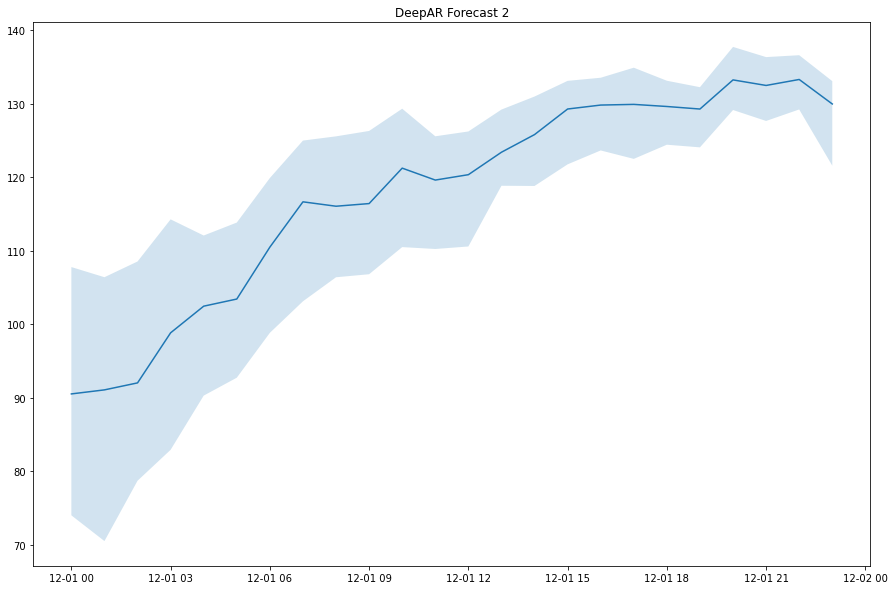

In [139]:

#def create_final_predictions(status3, forecast_arn):

import matplotlib.pyplot as plt
forecast_response_deep_2 = forecastquery.query_forecast(ForecastArn=forecast_arn,
                                                            Filters={"item_id":"maxcpu"}
                                                            )
fcst = forecast_response_deep_2['Forecast']['Predictions']
time_stamp = list(map(lambda x: pd.to_datetime(x['Timestamp']), fcst['p10']))
p10_fcst = list(map(lambda x: x['Value'], fcst['p10']))
p50_fcst = list(map(lambda x: x['Value'], fcst['p50']))
p90_fcst = list(map(lambda x: x['Value'], fcst['p90']))

plt.figure(figsize=(15, 10))
plt.plot(time_stamp, p50_fcst)
plt.fill_between(time_stamp, p10_fcst, p90_fcst, alpha=0.2)
plt.title("DeepAR Forecast 2");
#forecastResponse_Ops = forecastquery.query_forecast(ForecastArn=forecast_arn,
#                                                             Filters={"item_id":"EBSWriteOps"}
#                                                             )

prediction_df_cpu10 = pd.DataFrame.from_dict(forecast_response_deep_2['Forecast']['Predictions']['p10'])

prediction_df_cpu90 = pd.DataFrame.from_dict(forecast_response_deep_2['Forecast']['Predictions']['p90'])

# return prediction_df_Bytes, prediction_df_Ops 


In [140]:
prediction_df_cpu10

,Timestamp,Value
0,2020-12-01T00:00:00,74.024849
1,2020-12-01T01:00:00,70.523239
2,2020-12-01T02:00:00,78.725555
3,2020-12-01T03:00:00,82.932854
4,2020-12-01T04:00:00,90.298309
5,2020-12-01T05:00:00,92.732246
6,2020-12-01T06:00:00,98.831970
7,2020-12-01T07:00:00,103.116814
8,2020-12-01T08:00:00,106.385857
9,2020-12-01T09:00:00,106.798012


In [144]:
prediction_df_cpu10.values

array([['2020-12-01T00:00:00', 74.02484893798828],
       ['2020-12-01T01:00:00', 70.52323913574219],
       ['2020-12-01T02:00:00', 78.72555541992188],
       ['2020-12-01T03:00:00', 82.93285369873047],
       ['2020-12-01T04:00:00', 90.29830932617188],
       ['2020-12-01T05:00:00', 92.73224639892578],
       ['2020-12-01T06:00:00', 98.83197021484375],
       ['2020-12-01T07:00:00', 103.11681365966797],
       ['2020-12-01T08:00:00', 106.38585662841797],
       ['2020-12-01T09:00:00', 106.79801177978516],
       ['2020-12-01T10:00:00', 110.48554229736328],
       ['2020-12-01T11:00:00', 110.22916412353516],
       ['2020-12-01T12:00:00', 110.5702896118164],
       ['2020-12-01T13:00:00', 118.82321166992188],
       ['2020-12-01T14:00:00', 118.79475402832031],
       ['2020-12-01T15:00:00', 121.73439025878906],
       ['2020-12-01T16:00:00', 123.62495422363281],
       ['2020-12-01T17:00:00', 122.47697448730469],
       ['2020-12-01T18:00:00', 124.40245056152344],
       ['2020-12-01T

In [141]:
prediction_df_cpu90

,Timestamp,Value
0,2020-12-01T00:00:00,107.772186
1,2020-12-01T01:00:00,106.392365
2,2020-12-01T02:00:00,108.528526
3,2020-12-01T03:00:00,114.256554
4,2020-12-01T04:00:00,112.060310
5,2020-12-01T05:00:00,113.820000
6,2020-12-01T06:00:00,119.875404
7,2020-12-01T07:00:00,124.966003
8,2020-12-01T08:00:00,125.540207
9,2020-12-01T09:00:00,126.273796


In [145]:
#def create_result_dataframe(prediction_df_cpu):
results_df_cpu = pd.DataFrame(columns=['timestamp', 'value', 'source'])
    #results_df_Ops = pd.DataFrame(columns=['timestamp', 'value', 'source'])
for index, row in prediction_df_cpu90.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df_cpu = results_df_cpu.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'cpu_p90'} , ignore_index=True)
#     for index, row in prediction_df_Ops.iterrows():
#         clean_timestamp = dateutil.parser.parse(row['Timestamp'])
#         results_df_Ops = results_df_Ops.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'Ops_p50'} , ignore_index=True)
#     #pivot_df_Ops = results_df_Ops.pivot(columns='source', values='value', index="timestamp")
    #pivot_df_Bytes = results_df_Bytes.pivot(columns='source', values='value', index="timestamp")
#return results_df_cpu
        

In [146]:
results_df_cpu

,timestamp,value,source
0,2020-12-01 00:00:00,107.772186,cpu_p90
1,2020-12-01 01:00:00,106.392365,cpu_p90
2,2020-12-01 02:00:00,108.528526,cpu_p90
3,2020-12-01 03:00:00,114.256554,cpu_p90
4,2020-12-01 04:00:00,112.060310,cpu_p90
5,2020-12-01 05:00:00,113.820000,cpu_p90
6,2020-12-01 06:00:00,119.875404,cpu_p90
7,2020-12-01 07:00:00,124.966003,cpu_p90
8,2020-12-01 08:00:00,125.540207,cpu_p90
9,2020-12-01 09:00:00,126.273796,cpu_p90


In [147]:
#def clean_up_resources(forecast_arn, predictor_arn, ds_import_job_arn, datasetArn, datasetGroupArn):
fcst_utils.wait_till_delete(lambda: forecast.delete_forecast(ForecastArn=forecast_arn))
#print("forecast job and forecastArn cleaned up....")


Successful delete


In [148]:
fcst_utils.wait_till_delete(lambda: forecast.delete_predictor(PredictorArn=predictor_arn))
#print("Predictor job and PredictorArn cleaned up....")


Successful delete


In [149]:
fcst_utils.wait_till_delete(lambda: forecast.delete_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn))
#print("dataset import job cleaned up....")
fcst_utils.wait_till_delete(lambda: forecast.delete_dataset_import_job(DatasetImportJobArn=related_dataset_import_job_arn))

Successful delete
Successful delete


In [150]:
fcst_utils.wait_till_delete(lambda: forecast.delete_dataset(DatasetArn=ts_datasetArn))
#print("create dataset job and datasetArn cleaned up....")
fcst_utils.wait_till_delete(lambda: forecast.delete_dataset(DatasetArn=related_datasetArn))
#print("datasetgroup job and datasetgroupArn cleaned up....")


Successful delete
Successful delete


In [151]:
# Delete dataset group
forecast.delete_dataset_group(DatasetGroupArn=datasetGroupArn)

{'ResponseMetadata': {'RequestId': '8d0ece4e-d823-490a-80cd-28f711521f84',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 05 Dec 2020 07:11:02 GMT',
   'x-amzn-requestid': '8d0ece4e-d823-490a-80cd-28f711521f84',
   'content-length': '0',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [ ]:

#     #df = compound_dataframe(mybucket)
#     #preprocess_data(df)
#     datasetGroupArn, datasetArn, datasetName, project, s3DataPath, DATASET_FREQUENCY, TIMESTAMP_FORMAT=initialize_data_forecast()
    
#     try:
#         status1, ds_import_job_arn=create_data_imports(forecastHorizon, predictorName, algorithmArn, datasetGroupArn, datasetArn)
#         print("The value of status1: ", status1)
#     except AssertionError as error:
#         print(error)
#     else:
#         try:
#             status2, predictor_arn=create_predictor(predictorName, algorithmArn, forecastHorizon, datasetGroupArn)
#             print("The value of status2: ", status2)
#         except AssertionError as error:
#             print(error)
#         else:
#             try:
#                 status3, forecast_arn=create_forecast(forecastName, predictor_arn)
#                 print("The value of status3: ", status3)
#             except AssertionError as error:
#                 print(error)
#             else:
                
#                 prediction_df_Bytes, prediction_df_Ops=create_final_predictions(status3, forecast_arn)
#                 results_df_Bytes, results_df_Ops=create_result_dataframe(prediction_df_Bytes, prediction_df_Ops)
                
    

# copy_to_s3(client=client, df=results_df_Bytes, bucket=new_bucket, filepath=Deep_Bytes_key)  
# copy_to_s3(client=client, df=results_df_Ops, bucket=new_bucket, filepath=Deep_Ops_key)

# res = forecast.get_accuracy_metrics(PredictorArn=predictor_arn)
# RMSE = res['PredictorEvaluationResults'][0]['TestWindows'][0]['Metrics']['RMSE']
# with open("rmse.txt", "w") as file:
#     file.write(str(RMSE))
# client.upload_file(Filename='rmse.txt', Bucket= new_bucket, Key=RMSE_key)
# clean_up_resources(forecast_arn, predictor_arn, ds_import_job_arn, datasetArn, datasetGroupArn)
# endtime=datetime.now().strftime('%Y-%m-%d %H:%M:%S')
# print("cron ended at: {}".format(endtime))


In [ ]:

# copy to output bucket function
def copy_to_s3(client, df, bucket, filepath):
    
    #filepath=Deep_key
    csv_buf = StringIO()
    df.to_csv(csv_buf, header=True, index=False)
    csv_buf.seek(0)
    client.put_object(Bucket=bucket, Body=csv_buf.getvalue(), Key=filepath)
    print(f'Copy {df.shape[0]} rows to S3 Bucket {bucket} at {filepath}, Done!')

In [ ]:
copy_to_s3(client, results_df_cpu, new_bucket, filepath=Deep_key)

In [ ]:
copy_to_s3(client, results_df_cpu, new_bucket, filepath=Deep_RMSE_key)